# Image Colorization using VGGNet 
### Prerequisites
- OpenCV
- Medium understanding of CNN
- Intermediate understanding of Image Processing 
### Result 
- Hands on practice with a pre-trained neural network
- B&W images transformation into colorized imagery 

##### Dependencies
```bash
pip install opencv-python
pip install PIL
pip install numpy
pip install matplotlib
```


# VGGNet 
Visual Geometry Group Network or informally known as VGGNet, VGGNet consists of 16 convolutional layers and is very appealing because of its very uniform architecture. VGGNet is mainly used for extracting features from an image, for the image to be colorized, basically what it does is that it transforms the input image in such form that through convolution and batch normalization it turns input into a classification problem and makes the process of predictions much easier. 

# Image Colorization 
With the help of given VGGNet we can colorize an image. The process is called image colorization where we take a grayscale black and white image and return a colored Image The technique we’ll be using here is from Zhang et al.’s 2016 ECCV paper, Colorful Image Colorization

### Pre-Processing 
we see from line ```1-10``` that some caffemodel and prototxt are being loaded, which is us feeding the architecture and weights of the pre-trained nueral network(VGGNet) in our programming enviroment. After that from line ```16-17``` we make variables ```class8``` and ```conv8``` where we pick the particular layer from the NN which we want to feed some our processed data(image). 
In the lines such as ```26``` and ```27```
- Load centers for ab channel quantization used for rebalancing.
- Treat each of the points as 1×1 convolutions and add them to the model


These 2 fancy lines will be elaborated, as the first line says we are "quantizing" our layer, given that the layer already wasn't the way it was supposed to be, let's just say not according to our data for it to "work" with the data we provide, we load quantized bin centers. And soon after that, the second line suggests that we assign ```1x1```kernels corresponding to each of the 313 bin centers. Which means that we are convolving 1x1x313 with the given picture and that would multiply with our data and the NN layer accordingly. Basically what convolution by 1x1 kernal means here is that we multiply our matrix of 1x1 with the given picture and scale it afterwards according to our NN.   

In [1]:
import numpy as np
import cv2

#Initializing the arch and weights of the pre-trained model 
protofile = 'colorization_deploy_v2.prototxt'
model = 'colorization_release_v2.caffemodel'
ptsfile = 'pts_in_hull.npy'

print("[INFO] Loading Model...")
net = cv2.dnn.readNetFromCaffe(protofile, model)    #Loading the DNN in the NET variable, 
                                                    #this is where NN is loaded

pts = np.load(ptsfile)
print(pts.shape)

#Picking up the Layers from the VGGNet these are already assigned by 
#developer, we just pick them and use them
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
print(class8, conv8)

#We transpose the pts variable here so that it follows the same dimension as that of our newly 
#convolved matrix 
pts = pts.transpose().reshape(2, 313, 1, 1)
print(pts.shape)

#We pick the class8 and conv8 layers from the NN, quantize them and assing them 1x1 kernal
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype = "float32")]

[INFO] Loading Model...
(313, 2)
55 53
(2, 313, 1, 1)


## Image Selection and Display
This is here to show you the selection of our Black&White image and from here on we will be putting some pre-processing operation on the given image, in order for it to pass it forward in our VGGNet, ultimately filling in this image with colors.

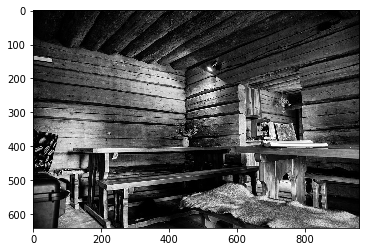

In [2]:
# Basically this is not related to code just here to show you that this is 
# our picture that we  try to colorize 

import matplotlib.pyplot as plt 
from PIL import Image
%matplotlib inline

pic = Image.open('bw.jpg')
pic_arr = np.asarray(pic)
plt.imshow(pic_arr)

## Pre-Processing on Input Data
When I say loaded data it just mean the picture we are loading in the given variable ```image```. 
We load the image using basic opencv command cv2.imread, next we apply some pre-processing on image,
- Scale image pixel intensities to range from ```[0,1]``` 
- Convert the image from Blue, Gree, Red to Lab

Why we scale image to range from 0-1? Because if the intensities vary from 0-254 they might take a little to much time to even do one forward pass in VGGNet, we do it for the sake of efficiency. 

Why do we convert image from RGB to Lab? First up, you might know what BRG/RGB color channels are, but Lab seems a bit new, 
### Lab
Like the RGB color space, it is a 3-channel color space, but unlike the RGB color space, color information is encoded only in the a (green-red component) and b (blue-yellow component) channels. The L (lightness) channel encodes intensity information only.


Now back to the WHY part, to simplify the why part, we can say that the ab space of the 'Lab' color space is quantized into 313 bins. Instead of finding the a and b values for every pixel, because of this quantization, we simply need to find a bin number between 0 and 312. Yet another way of thinking about the problem is that we already have the L channel that takes values from 0 to 255, and we need to find the ab channel that takes values between 0 to 312. So the color prediction task is now turned into a multinomial classification problem where for every gray pixel there are 313 classes to choose from. Basically what it does is that, it turns our huge problem of image colorization into a classification problem where the NN just has to predict as to where does each color channel is classified in the 0-312 range! I think that is incredible.

In [3]:
image = cv2.imread('bw.jpg')                   #We load our image
scaled = image.astype("float32") / 255.0       #We scale our image to range only in [0,1] range
lab = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)  #We convert our image into Lab color

## Resizing Input Data
```lab224``` variable has the width and height assigned 224 which is the only required dimension for the NN.


```L``` variable is where we take our the L channel from the L(ab) channels as you can see we trim our array accordingly. 


Why do we subtract it from 50? Well mostly, the lightness channel ranges from 0 to 100. So we subtract 50 to center it at 0. And we center it so that we can convolve it in our NN from one end to another properly. 

In [4]:
lab224 = cv2.resize(lab, (224, 224))   #We resize our lab converted image to lab224 where we assign it 
                                       #224 width and 224 height which is the only dimension that NN accepts
    
L = lab224[:,:,0]                      #We seperate the L channel from Lab channels and assigns it to var 'L'
L -= 50                                #We perform mean subtraction, so that we re-center our picture

## Neural Network Forward Pass
From line ```10-13``` we put the input image back to where we started from which is 640x960 with 2 color channel. 

In [5]:
import time 
net.setInput(cv2.dnn.blobFromImage(L))        #The pre-processed L var is being converted from a blob 

st = time.time()                              #Time counter starts here

abf = net.forward()                           #Passes the Image in VGGNet
print("Time Taken {}".format(time.time()-st)) #Time taken for the NN to process our input data(image)

print(abf.shape)
abf = abf[0, :, :, :].transpose((1,2,0))      #Turning image back to the output dimensions 
print(abf.shape)

ab = cv2.resize(abf, (image.shape[1], image.shape[0]))  #Here, From there, we resize the predicted ab  
                                                        #volume to be the same dimensions as our input 
print(ab.shape)

Time Taken 0.7804913520812988
(1, 2, 56, 56)
(56, 56, 2)
(640, 960, 2)


## Colorizing and Displaying 
The most important part of colorizing is combining the predicted values with the original picture, hence finally coloring the B&W image. How we do that here,
- We first again take the ```L``` channel from the original black and white image 
- Next we concatenate the original 'L' intensity channel and concatenate it with the predicted ab channel obtained from the NN forward pass. 
- Third we obtain the new variable ```colorized```, which is the colorized image! 

In [6]:
L = lab[:,:,0]                                                 #L channel splitting it for use from the original image 
#print("L channel: "L.shape)        
#print("ab channel"ab.shape)         
colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)  #Concatenating the L from original image with
#print(colorized.shape)                                         #the predicted ab channel from NN 

colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)         #Finally converting the image back to BGR format
colorized = np.clip(colorized, 0, 1)                           #Clipping any pixel intensities that fall outside the range [0, 1] 

colorized = (255* colorized).astype("uint8")

#Here onward we just showcase our converted images Before vs After 
cv2.imshow("Original", image)
cv2.imshow("Colorized", colorized)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Predicted Colorization 
unrelated to code just here to showcase the results without the end-use to run the ipython notebook 

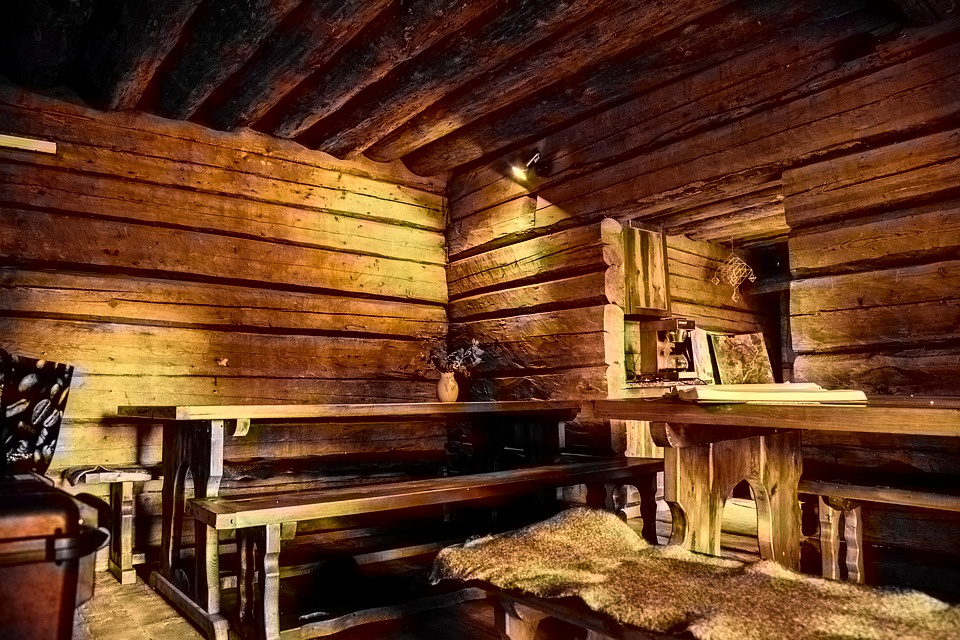

In [7]:
cv2.imwrite('color.jpg',colorized) #imwrite() used for writing images on file
picture = Image.open('color.jpg')
picture

## Video Colorization using VGGNet
From here onward we will be doing the same things we did before i.e,
- Initialize the NN pre-trained model
- Make predictions on our Black and White Video
- Save the colorized video 

For the Video Colorization we split our code in two functional blocks,
- First : Initialization of VGGNet, CaffeModel arch and weights, named ```col_initialization```
- Second : Making predictions on the Video for the sake of colorization, named ```colorize```



## Loading Libs

In [8]:
from tkinter import filedialog
from tkinter import Tk
import cv2
import numpy as np

In [9]:
def col_initialization():
    #Initializing the arch and weights of the pre-trained model
    global net
    protofile = 'colorization_deploy_v2.prototxt'
    model = 'colorization_release_v2.caffemodel'
    ptsfile = 'pts_in_hull.npy'
    
    net = cv2.dnn.readNetFromCaffe(protofile, model)   #Loading the DNN in the NET variable,
    pts = np.load(ptsfile)                             #this is where NN is loaded
    
    #Picking up the Layers from the VGGNet these are already assigned by 
    #developer, we just pick them and use them
    class8 = net.getLayerId("class8_ab")
    conv8 = net.getLayerId("conv8_313_rh")
    
    #We transpose the pts variable here so that it follows the same dimension as that of our newly 
    #convolved matrix 
    pts = pts.transpose().reshape(2, 313, 1, 1)
    
    #We pick the class8 and conv8 layers from the NN, quantize them and assing them 1x1 kernal
    net.getLayer(class8).blobs = [pts.astype("float32")]
    net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

def colorize(data = None, flag = 0, usercam = False, returndata = False):
    if flag == 0:
        #This fragment of code opens the cam for split second just to click a picture
        if usercam:
            cap=cv2.VideoCapture(0)
            ret,frame=cap.read()
            data= cv2.flip(frame,1)
            cap.release()
        else:
        #This Fragment here, opens a classic input window where the user chooses his/her file
            root = Tk()
            root.filename =  filedialog.askopenfilename(title = "Select Image")
            root.withdraw()
            data = cv2.imread(root.filename)
    
    scaled = data.astype("float32") / 255.0       #We scale our image to range only in [0,1] range
    lab = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)  #We convert our image into Lab color
    lab224 = cv2.resize(lab, (224, 224))           #We resize our lab converted image to lab224 where we assign it 
                                                   #224 width and 224 height which is the only dimension that NN accepts
    
    L = lab224[:,:,0]       #We seperate the L channel from the original image
    L -= 50                 #We perform mean subtraction, so that we re-center our picture
    
    net.setInput(cv2.dnn.blobFromImage(L))   #Setting up the input image coverting it from blob
    abf = net.forward()                      #Forward pass in NN our data
    abf = abf[0, :, :, :].transpose((1, 2, 0))   #Changing the dimensions of our image matrix to obtain the original dimension
    ab = cv2.resize(abf, (data.shape[1], data.shape[0]))   #Transforming our colorized image back to its original dimension
    
    L = lab[:,:,0]        #L channel of the original image
    colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)   #Concatenating predicted values of ab channel and L channel from original image
    colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)     #converting image from lab back to RGB format
    colorized = np.clip(colorized, 0, 1)                       #Clipping any pixel intensities that fall outside the range [0, 1] 
    
    colorized_pic = (colorized *255).astype("uint8")         #Finally getting out original color channels 
    
    if returndata:
        return colorized_pic
    else:
        cv2.imshow("Coloring", colorized_pic)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

## Testing 
Checking whether the above methods are working properly or not!

### Initialization of Method

In [10]:
col_initialization()

### Picture Input using user camera
- Flag 0 means we're specifying input
- Flag 1 means the input is specified in the code

In [11]:
colorize(usercam=True)

### Picture Input by Default Args

In [12]:
colorize()

# Internship Task
Here I put a while loop to keep the neural network running and to keep it predicting values in real time, it is a mixture of already mentioned program


In [13]:
import numpy as np
import cv2

col_initialization()

cap = cv2.VideoCapture('b&w.mp4')    #Video is captured in this variable

fourcc = cv2.VideoWriter_fourcc(*'XVID')                       #The format of our new video being initialized
out = cv2.VideoWriter('colored.mp4',fourcc, 20.0, (480,360))  #Colorized video being copied here and saved

while(True):                               #loop runs until the video isn't over
    ret, frame = cap.read()                #Video being played 
    if ret == True:
        framen = colorize(frame ,flag = 1, usercam = False, returndata = True)               #Each frame is being passed from NN here 

        final = np.hstack((frame,framen))    #here we use hstack to, literally stack both the videos horizontally
        
        cv2.imshow('Orignal VS Colorized Frame',final)        #This function shows the videos
        out.write(framen)                                      #Here the colorized video is being written off

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()